In [2]:
import copy
from typing import Optional, List

from fastai.distributed import *
from fastai.vision.all import *

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, Tensor
from torchvision import transforms

from scipy.spatial import distance
import numpy as np

#from models.encoder import EncoderModule
#from models.backbone import Backbone, NoBackbone

In [3]:
from PIL import Image
import requests

In [4]:
H = 32
W= 32

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406])
])

In [5]:
def img_patches(img_t, grid_l):
    #torch.Tensor.unfold(dimension, size, step)
    #slices the images into grid_l*grid_l size patches
    patches = img_t.data.unfold(1, 3, 3).unfold(2, grid_l, grid_l).unfold(3, grid_l, grid_l)
    a, b, c, d, e, f, g = patches.shape
    patches = patches.reshape(a, c, d, e, f, g)
    #print(patches.shape)
    return patches


def grid_gram_matrix(input):

    a, b, c, d, e, f = input.shape
    # a=batch size
    # b=horizontal patches
    # c = vertical patches
    # d=number of feature maps
    # (e,f)=dimensions of a f. map (N=e*f)

    features = input.reshape(a * b * c, d, e*f)  # resise F_XL into \hat F_XL
    #print(features.shape)
    # compute the gram product

    G = torch.mm(features[0], features[0].t())

    for i in range(1,a*b*c):
        g = torch.mm(features[i], features[i].t())
        G= torch.cat((G, g), 0)


    G = G.div(d * e * f).reshape(a, b, c, d, d)

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    
    return G


def grids_list(batch_size, width, height, grid_l=2): #COMPUTED ONCE BEFORE TRAINING
    w = width
    h = height
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l
    qtd_grids = qt_hor_grids*qt_ver_grids
    c = 0
    grids_list = []
    for i in range(qtd_grids):
        hor_pos = i//qt_hor_grids
        ver_pos = c
        c = c+1
        grid = [hor_pos,ver_pos]
        grids_list.append(grid)
        if c == qt_ver_grids:
            c=0
    return grids_list

def gram_dist_matrix(batch,grids,grid_l=2):
    patches = img_patches(batch, grid_l)
    #print(patches.shape)
    Grid = grid_gram_matrix(patches)
    #print(Grid.shape)
    bs = batch.shape[0]
    #print(bs)
    MSE = nn.MSELoss()

    mse_grid = []
    for k in range(bs):
        dist_grid = []
        for g in range(len(grids)):
            dist_pair_list = []
            for n in range(len(grids)):
                dist_pair_list.append(MSE(Grid[k][grids[g][0]][grids[g][1]], Grid[k][grids[n][0]][grids[n][1]]))
            dist_grid.append(dist_pair_list)
        mse_grid.append(dist_grid)
    
    dist_matrix = torch.tensor(np.array(mse_grid))
    
    for i in range(bs):
        dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
        dist_matrix[i] -= dist_matrix[i].min(1, keepdim=True)[0]
        dist_matrix[i] /= dist_matrix[i].max(1, keepdim=True)[0]
        dist_matrix[i] = dist_matrix[i].view(1, len(grids), len(grids))
    
    return dist_matrix


#######################################3
########################################3
#######################################33

def distance_matrix(batch_size, width, height, grid_l=3):

    w = width
    h = height
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l
    qtd_grids = qt_hor_grids*qt_ver_grids
    c = 0
    grids = []
    for i in range(qtd_grids):
        hor_pos = i//qt_hor_grids
        ver_pos = c
        c = c+1
        grid = [hor_pos,ver_pos]
        grids.append(grid)
        if c == qt_ver_grids:
            c=0

    dist_grid = []
    for g in range(len(grids)):
        dist_pair_list = []
        for n in range(len(grids)):
            dist_pair_list.append(distance.cityblock(grids[g], grids[n]))
        dist_grid.append(dist_pair_list)

    dist_matrix = torch.tensor(np.array(dist_grid))

    return dist_matrix

def grids_matrix(batch_size, width, height, grid_l=3):

    w = width
    h = height
    len_input_seq = h*w
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l


    grid_list = []
    for i in range(h):
        row_grid_list = []
        preliminar_ver_grid = i//grid_l
        if preliminar_ver_grid != 0:
            preliminar_ver_grid = preliminar_ver_grid*qt_hor_grids

        for h in range(w):
            preliminar_grid = h//grid_l+preliminar_ver_grid
            row_grid_list.append(preliminar_grid)

        grid_list.append(row_grid_list)
    grid_matrix = torch.tensor(np.array(grid_list))

    return grid_matrix

def penalty_factor(dist_matrix, penalty_factor="1", alpha=1):
    if penalty_factor == "1" or penalty_factor =="distraction":
        pf_matrix = ((dist_matrix+1))**alpha
        return pf_matrix
    if penalty_factor == "2" or penalty_factor =="misdirection":
        pf_matrix = alpha*((torch.max(dist_matrix)//2)-dist_matrix+0.1)**3
        return pf_matrix


def penalty_matrix(batch_size, width, height, grid_matrix, dist_matrix, grid_l=2):
    bs,_,_ = dist_matrix.shape
    pep = []
    for s in range(bs):
        pf_matrix = penalty_factor(dist_matrix[s], penalty_factor="1", alpha=1)
        w = width
        h = height

        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l
        qtd_grids = qt_hor_grids*qt_ver_grids

        penalty_mask = []
        for i in range(qtd_grids):
            ref_column = pf_matrix[i]
            p_matrix = grid_matrix.type(torch.FloatTensor)
            for j in range(1,len(ref_column)):
                #print(float(j))
                p_matrix[p_matrix==j]=float(ref_column[j])
            p_matrix[p_matrix==0]=float(ref_column[0])
            penalty_mask.append(p_matrix)

        print(len(penalty_mask))    

        penalty_enc = []
        for i in range(h):
            penalty_row = []
            for j in range(w):
                #print(grid_matrix[i,j])
                #print(penalty_mask[grid_matrix[i,j]].shape)
                penalty_row.append(penalty_mask[grid_matrix[i,j]])
                #print(len(penalty_row))
            generic_tensor = Tensor(h,w)
            penalty_row_tensor = torch.cat(penalty_row, out=generic_tensor)
            penalty_enc.append(penalty_row_tensor)
            #print(penalty_row_tensor.shape)
            #break

        b = torch.Tensor(h, w, h, w)
        c=torch.cat(penalty_enc, out=b)
        c = c.view(h, w, h, w)
        pep.append(c)

    d = torch.Tensor(batch_size, h, w, h, w)
    penalty_encoding_pattern = torch.cat(pep, out=d)
    penalty_encoding_pattern = penalty_encoding_pattern.view(batch_size, h, w, h, w)

    return penalty_encoding_pattern

In [6]:
batch_size = 10
width = 256
height = 256
grid_l=16 
pf="1"
alpha=1

In [7]:
def penalty_mask(batch_size, f_map_w, f_map_h, grid_l=4, penalty_factor="1", alpha=1):
    dist_matrix = distance_matrix(batch_size, f_map_w, f_map_h, grid_l)
    grids_matrix = grids_matrix(batch_size, f_map_w, f_map_h, grid_l)
    pf_matrix = penalty_factor(dist_matrix, penalty_factor, alpha)

    penalty_mask = penalty_matrix(batch_size, f_map_w, f_map_h, grids_matrix, pf_matrix, grid_l)
    
    return penalty_mask

In [8]:
dist_matrix = distance_matrix(batch_size, width, height, grid_l)

In [12]:
dist_matrix.shape

torch.Size([256, 256])

In [9]:
g_matrix = grids_matrix(batch_size, width, height, grid_l)

In [10]:
pf_matrix = penalty_factor(dist_matrix, pf, alpha)

In [11]:
penalty_mask = penalty_matrix(batch_size, width, height, g_matrix, pf_matrix, grid_l)

ValueError: not enough values to unpack (expected 3, got 2)

In [161]:
penalty_mask.shape

torch.Size([10, 32, 32, 32, 32])

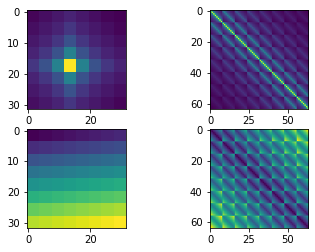

In [162]:
plt.subplot(221)
plt.imshow(penalty_mask[0][17][14])
plt.subplot(222)
plt.imshow(pf_matrix)
plt.subplot(223)
plt.imshow(g_matrix)
plt.subplot(224)
plt.imshow(dist_matrix)

In [42]:
class StyleLoss(nn.Module):

    def __init__(self):
        super(StyleLoss, self).__init__()

    def forward(self, input,target_feature):
        G = gram_matrix(input)
        target = gram_matrix(target_feature)
        self.loss = F.mse_loss(G, target)
        return self.loss

In [43]:
styleLoss = StyleLoss()

In [45]:
MSE = nn.MSELoss()
MSE(gram_m,gram_m2)

Input shape: torch.Size([1, 3, 32, 32])


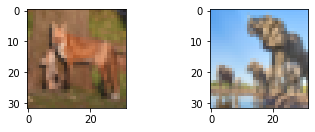

In [46]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url2 = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/elephant_1280p.jpg?itok=UT_i17Yh'
im = Image.open(requests.get(url, stream=True).raw)
img = transform(im).unsqueeze(0)
im2 = Image.open(requests.get(url2, stream=True).raw)
img2 = transform(im2).unsqueeze(0)
batch= torch.cat((img, img2), 0)
print("Input shape:", img.shape)
plt.subplot(221)
plt.imshow(batch[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(batch[1].cpu().permute(1, 2, 0))

In [47]:
patches = img_patches(batch, grid_l)
print(patches.shape)

torch.Size([2, 8, 8, 3, 4, 4])


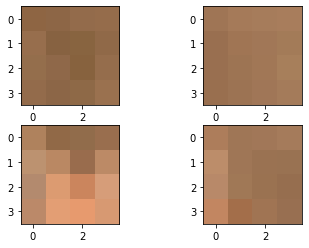

In [48]:
plt.subplot(221)
plt.imshow(patches[0][0][2].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(patches[0][0][3].cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(patches[0][1][2].cpu().permute(1, 2, 0))
plt.subplot(224)
plt.imshow(patches[0][1][3].cpu().permute(1, 2, 0))

In [53]:
Grid = grid_gram_matrix(patches)
print(Grid.shape)

torch.Size([2, 8, 8, 3, 3])


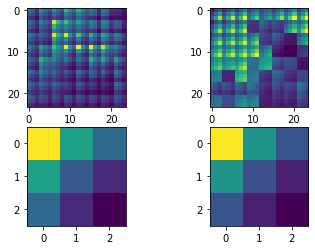

In [99]:
plt.subplot(221)
plt.imshow(Grid.permute(0,1,3,2,4).reshape(2, 8*3, 8*3)[0].cpu())
plt.subplot(222)
plt.imshow(Grid.permute(0,1,3,2,4).reshape(2, 8*3, 8*3)[1].cpu())
plt.subplot(223)

In [96]:
G.permute(0,1,3,2,4).reshape(2, 8*3, 8*3).shape

torch.Size([2, 24, 24])

In [100]:
#[2, 8, 8, 3, 3]
a, b, c, d, e = Grid.shape
print(a, b, c, d, e)
# for k in range(a):
for i in range(b):
    for j in range(c):
        
        

2 8 8 3 3


In [126]:
bs = 2
w = 32
h = 32
qt_hor_grids = w//4
qt_ver_grids = h//4
c = 0
qtd_grids = 64
grids = []
for i in range(qtd_grids):
    hor_pos = i//qt_hor_grids
    ver_pos = c
    c = c+1
    grid = [hor_pos,ver_pos]
    grids.append(grid)
    if c == qt_ver_grids:
        c=0
#print(len(grids))
MSE = nn.MSELoss()

mse_grid = []
for k in range(bs):
    dist_grid = []
    for g in range(len(grids)):
        dist_pair_list = []
        for n in range(len(grids)):
            dist_pair_list.append(MSE(Grid[k][grids[g][0]][grids[g][1]], Grid[k][grids[n][0]][grids[n][1]]))
        dist_grid.append(dist_pair_list)
    mse_grid.append(dist_grid)
    

dist_matrix = torch.tensor(np.array(mse_grid))

torch.Size([2, 64, 64])


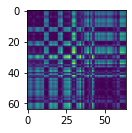

In [130]:
print(dist_matrix.shape)
plt.subplot(221)
plt.imshow(dist_matrix[1].cpu())

In [119]:
MSE = nn.MSELoss()
MSE(Grid[0][grids[0][0]][grids[0][1]],Grid[0][grids[1][0]][grids[1][1]])

tensor(0.0002)

In [118]:
Grid[0][grids[0][0]][grids[0][1]]

tensor([[0.0819, 0.0646, 0.0376],
        [0.0646, 0.0516, 0.0295],
        [0.0376, 0.0295, 0.0176]])

In [304]:
def grids_list(batch_size, width, height, grid_l=2):
    w = width
    h = height
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l
    qtd_grids = qt_hor_grids*qt_ver_grids
    c = 0
    grids_list = []
    for i in range(qtd_grids):
        hor_pos = i//qt_hor_grids
        ver_pos = c
        c = c+1
        grid = [hor_pos,ver_pos]
        grids_list.append(grid)
        if c == qt_ver_grids:
            c=0
    return grids_list

def gram_dist_matrix(batch,grids,grid_l=2):
    patches = img_patches(batch, grid_l)
    #print(patches.shape)
    Grid = grid_gram_matrix(patches)
    #print(Grid.shape)
    bs = batch.shape[0]
    #print(bs)
    MSE = nn.MSELoss()

    mse_grid = []
    for k in range(bs):
        dist_grid = []
        for g in range(len(grids)):
            dist_pair_list = []
            for n in range(len(grids)):
                dist_pair_list.append(MSE(Grid[k][grids[g][0]][grids[g][1]], Grid[k][grids[n][0]][grids[n][1]]))
            
            dist_grid.append(dist_pair_list)
        mse_grid.append(dist_grid)
    
    dist_matrix = torch.tensor(np.array(mse_grid))
    
    for i in range(bs):
        dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
        dist_matrix[i] -= dist_matrix[i].min(1, keepdim=True)[0]
        dist_matrix[i] /= dist_matrix[i].max(1, keepdim=True)[0]
        dist_matrix[i] = dist_matrix[i].view(1, len(grids), len(grids))
    
    return dist_matrix

In [305]:
grids = grids_list(batch_size=2, width=32, height=32, grid_l=2)
print(len(grids))

256


In [306]:
dist_matrix = gram_dist_matrix(batch,grids,grid_l=2)
print(dist_matrix.shape)

torch.Size([2, 256, 256])


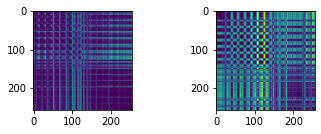

In [250]:
plt.subplot(221)
plt.imshow(dist_matrix[0].cpu())
plt.subplot(222)
plt.imshow(dist_matrix[1].cpu())

In [226]:
def grids_matrix(batch_size, width, height, grid_l=3):

    w = width
    h = height
    len_input_seq = h*w
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l


    grid_list = []
    for i in range(h):
        row_grid_list = []
        preliminar_ver_grid = i//grid_l
        if preliminar_ver_grid != 0:
            preliminar_ver_grid = preliminar_ver_grid*qt_hor_grids

        for h in range(w):
            preliminar_grid = h//grid_l+preliminar_ver_grid
            row_grid_list.append(preliminar_grid)

        grid_list.append(row_grid_list)
    grid_matrix = torch.tensor(np.array(grid_list))

    return grid_matrix

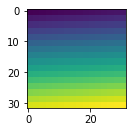

In [253]:
gd_mtx = grids_matrix(batch_size=2, width=32, height=32, grid_l=2)
gd_mtx.shape
plt.subplot(221)
plt.imshow(gd_mtx.cpu())

In [267]:
def penalty_factor(dist_matrix, penalty_factor="1", alpha=1):
    if penalty_factor == "1" or penalty_factor =="distraction":
        pf_matrix = (dist_matrix+1)**alpha
        return pf_matrix
    if penalty_factor == "2" or penalty_factor =="misdirection":
        pf_matrix = alpha*((torch.max(dist_matrix)//2)-dist_matrix+0.1)**3
        return pf_matrix
pfmtx = penalty_factor(dist_matrix[0], penalty_factor="1", alpha=1)

In [266]:
pfmtx.shape

torch.Size([2, 256, 256])

In [295]:
def penalty_matrix(batch_size, width, height, grid_matrix, dist_matrix, grid_l=2):
    bs,_,_ = dist_matrix.shape
    pep = []
    for s in range(bs):
        pf_matrix = penalty_factor(dist_matrix[s], penalty_factor="1", alpha=1)
        w = width
        h = height

        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l
        qtd_grids = qt_hor_grids*qt_ver_grids

        penalty_mask = []
        for i in range(qtd_grids):
            ref_column = pf_matrix[i]
            p_matrix = grid_matrix.type(torch.FloatTensor)
            for j in range(1,len(ref_column)):
                #print(float(j))
                p_matrix[p_matrix==j]=float(ref_column[j])
            p_matrix[p_matrix==0]=float(ref_column[0])
            penalty_mask.append(p_matrix)

        print(len(penalty_mask))    

        penalty_enc = []
        for i in range(h):
            penalty_row = []
            for j in range(w):
                #print(grid_matrix[i,j])
                #print(penalty_mask[grid_matrix[i,j]].shape)
                penalty_row.append(penalty_mask[grid_matrix[i,j]])
                #print(len(penalty_row))
            generic_tensor = Tensor(h,w)
            penalty_row_tensor = torch.cat(penalty_row, out=generic_tensor)
            penalty_enc.append(penalty_row_tensor)
            #print(penalty_row_tensor.shape)
            #break

        b = torch.Tensor(h, w, h, w)
        c=torch.cat(penalty_enc, out=b)
        c = c.view(h, w, h, w)
        pep.append(c)

    d = torch.Tensor(batch_size, h, w, h, w)
    penalty_encoding_pattern = torch.cat(pep, out=d)
    penalty_encoding_pattern = penalty_encoding_pattern.view(batch_size, h, w, h, w)

    return penalty_encoding_pattern



pmtx = penalty_matrix(batch_size=2, width=32, height=32, grid_matrix=gd_mtx, dist_matrix=dist_matrix, grid_l=2)
pmtx.shape

256
256


torch.Size([2, 32, 32, 32, 32])

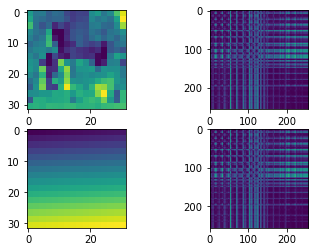

In [301]:
plt.subplot(221)
plt.imshow(pmtx[0][15][25])
plt.subplot(222)
plt.imshow(pfmtx)
plt.subplot(223)
plt.imshow(x)
plt.subplot(224)
plt.imshow(dist_matrix[0])

In [273]:
w = 32
h = 32

qt_hor_grids = w//2
qt_ver_grids = h//2
qtd_grids = qt_hor_grids*qt_ver_grids

pf_matrix = pfmtx
grid_matrix = gd_mtx

penalty_mask = []
for i in range(qtd_grids):
    ref_column = pf_matrix[i]
    p_matrix = grid_matrix.type(torch.FloatTensor)
    for j in range(1,len(ref_column)):
        #print(float(j))
        p_matrix[p_matrix==j]=float(ref_column[j])
    p_matrix[p_matrix==0]=float(ref_column[0])
    penalty_mask.append(p_matrix)

print(len(penalty_mask))    

256


In [291]:
penalty_enc = []
for i in range(h):
    penalty_row = []
    for j in range(w):
        #print(grid_matrix[i,j])
        #print(penalty_mask[grid_matrix[i,j]].shape)
        penalty_row.append(penalty_mask[grid_matrix[i,j]])
        #print(len(penalty_row))
    generic_tensor = Tensor(h,w)
    penalty_row_tensor = torch.cat(penalty_row, out=generic_tensor)
    penalty_enc.append(penalty_row_tensor)
    #print(penalty_row_tensor.shape)
    #break

b = torch.Tensor(h, w, h, w)
c=torch.cat(penalty_enc, out=b)
c = c.view(h, w, h, w)

In [292]:
c.shape

torch.Size([32, 32, 32, 32])

In [289]:
p_matrix[p_matrix==0]

tensor([0., 0., 0., 0.])

In [290]:
ref_column[0]

tensor(1.0141)

In [300]:
def grids_matrix(width, height, grid_l=2):

    w = width
    h = height
    len_input_seq = h*w
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l


    grid_list = []
    for i in range(h):
        row_grid_list = []
        preliminar_ver_grid = i//grid_l
        if preliminar_ver_grid != 0:
            preliminar_ver_grid = preliminar_ver_grid*qt_hor_grids

        for h in range(w):
            preliminar_grid = h//grid_l+preliminar_ver_grid
            row_grid_list.append(preliminar_grid)

        grid_list.append(row_grid_list)
    grid_matrix = torch.tensor(np.array(grid_list))

    return grid_matrix
x=grids_matrix(width=32, height=32, grid_l=2)

In [302]:
def img_patches(batch, grid_l):
    #torch.Tensor.unfold(dimension, size, step)
    #slices the images into grid_l*grid_l size patches
    patches = batch.data.unfold(1, 3, 3).unfold(2, grid_l, grid_l).unfold(3, grid_l, grid_l)
    a, b, c, d, e, f, g = patches.shape
    patches = patches.reshape(a, c, d, e, f, g)
    #print(patches.shape)
    return patches
ptc = img_patches(batch,2)

In [303]:
ptc.shape

torch.Size([2, 16, 16, 3, 2, 2])